In [1]:
#!/home/anuj.mishra/anaconda3/envs/gwpy/bin/python

import numpy as np

import sys
import mpmath
from mpmath import hyp1f1
import math
import scipy
from scipy.interpolate import interp1d
import pandas as pd

from copy import deepcopy

from itertools import product
from functools import partial
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import pickle

sys.path.append('../data/')
sys.path.append('../../src/cythonized_pnt_lens_class/')  #path to the dir containing cython module
import pnt_lens_class 
pnt_lens_py = pnt_lens_class.point_lens()

# loading Cython version of the point lens class
import cythonized_pnt_lens_class as pnt_lens_cy
   
    

## 1. Loading lookup table and reconstructing the grid form the data

In [4]:
import pickle

lookuptable_file ='../data/point_lens_Ff_lookup_table_Geo_relErr_1p0_Mlz_1e-1_1e5_ys_1e-3_5.pkl'
# label = 'point_lens_Ff_lookup_table_Geo_relErr_1p0_Mlz_1e-1_1e5_ys_1e-3_10'
# label = 'point_lens_Ff_lookup_table_Geo_relErr_1p0_Mlz_1e-1_1e5_ys_1e-3_10'

ymax=5
with open(lookuptable_file, 'rb') as f:
    Ff_grid = pickle.load(f)

print('\nNumber of entries in lookup_table: ', len(Ff_grid)) 
Ff_grid[str(0)]


Number of entries in lookup_table:  54999


{'y': 0.001,
 'ws': array([1.00000000e-04, 1.00311921e-04, 1.00624816e-04, ...,
        1.29192783e+04, 1.29595763e+04, 1.30000000e+04]),
 'Ffs_real': array([ 1.00007841,  1.00007865,  1.0000789 , ..., 36.68948313,
        38.02367284, 39.25979126]),
 'Ffs_imag': array([-5.16254140e-04, -5.17708358e-04, -5.19166626e-04, ...,
        -1.69270086e+01, -1.57181518e+01, -1.44015241e+01])}

## 2. Relevant Functions

In [3]:
############################################# Custom Source Models for Bilby ######################################################
### I. Point Lens Parameter Estimation ###

from scipy.interpolate import interp1d
import sys
sys.path.append('/home/anuj.mishra/git_repos/GWMAT/src/cythonized_pnt_lens_class/')  #path to the dir containing cython module
# loading Cython version of the point lens class
import cythonized_pnt_lens_class as pnt_lens_cy

## functions
def y_w_grid_data(Ff_grid):
    ys_grid = np.array([Ff_grid[str(i)]['y'] for i in range(len(Ff_grid))])
    ws_grid = Ff_grid[str(np.argmin(ys_grid))]['ws']
    #ys_grid = np.sort(ys_grid)
    return ys_grid, ws_grid

def y_index(yl, ys_grid):
    return np.argmin(np.abs(ys_grid - yl))

def w_index(w, ws_grid):
    return np.argmin(np.abs(ws_grid - w))

def pnt_Ff_lookup_table(fs, Mlz, yl, ys_grid, ws_grid, extrapolate=True):
    wfs = np.array([pnt_lens_cy.w_of_f(f, Mlz) for f in fs])
    wc = pnt_lens_cy.wc_geo_re1p0(yl)

    wfs_1 = wfs[wfs <= np.min(ws_grid)]
    Ffs_1 = np.array([1]*len(wfs_1))

    wfs_2 = wfs[(wfs > np.min(ws_grid))&(wfs <= np.max(ws_grid))]
    wfs_2_wave = wfs_2[wfs_2 <= wc]
    wfs_2_geo = wfs_2[wfs_2 > wc]

    i_y  = y_index(yl, ys_grid)
    tmp_Ff_dict = Ff_grid[str(i_y)]
    ws = tmp_Ff_dict['ws']
    Ffs = tmp_Ff_dict['Ffs_real'] + 1j*tmp_Ff_dict['Ffs_imag']
    fill_val = ['interpolate', 'extrapolate'][extrapolate]
    i_Ff = interp1d(ws, Ffs, fill_value=fill_val)
    Ffs_2_wave = i_Ff(wfs_2_wave)
    
    Ffs_2_geo = np.array([pnt_lens_cy.point_Fw_geo(w, yl) for w in wfs_2_geo])

    wfs_3 = wfs[wfs > np.max(ws_grid) ]
    Ffs_3 = np.array([pnt_lens_cy.point_Fw_geo(w, Mlz) for w in wfs_3])

    Ffs = np.concatenate((Ffs_1, Ffs_2_wave, Ffs_2_geo, Ffs_3))
    assert len(Ffs)==len(fs), 'len(Ffs) = {} does not match len(fs) = {}'.format(len(Ffs), len(fs))
    return Ffs     


ys_grid, ws_grid = y_w_grid_data(Ff_grid)    

## 3. Lookup table checks

### 1. accuracy for overall parameter space

100%|██████████| 900/900 [00:31<00:00, 28.47it/s]


0.03766430245505439


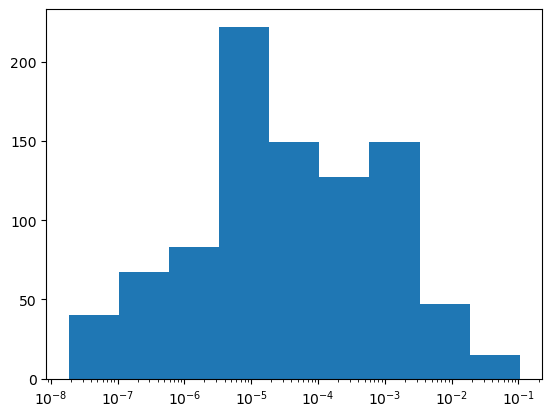

In [5]:
ys_grid, ws_grid = y_w_grid_data(Ff_grid)

t1 = time.time()
Mlzs = np.logspace(-1, 5, 30)
ys = np.logspace(-3, np.log10(ymax), 30)
fs = np.arange(0, 1024, 1/2)
input_prms = np.array(list(product(Mlzs, ys)))

def comp_residual(i):
    Mlz, yl = input_prms[i]
    Ffs_LT = pnt_Ff_lookup_table(fs, Mlz, yl, ys_grid, ws_grid)
    if yl > 1e-2:
        Ffs_A = np.array([pnt_lens_cy.point_Ff_eff(f, Mlz, yl) for f in fs])
    else:
        wfs = [pnt_lens_cy.w_of_f(f, Mlz) for f in fs]
        Ffs_A = np.array([pnt_lens_cy.point_Fw(wf, yl) for wf in wfs])
        
    residual = np.linalg.norm( Ffs_A/np.linalg.norm(Ffs_A) - Ffs_LT/np.linalg.norm(Ffs_LT) )
    return residual

if __name__=='__main__':
    import multiprocessing as mp
    pool = mp.Pool(8)
    residuals = np.array(list(tqdm(pool.imap(comp_residual, np.arange(len(input_prms))), total=len(input_prms))))
    
t2 = time.time()
print((t2-t1)/len(input_prms))

if np.min(residuals) != 0:
    plt.hist(residuals, bins=np.logspace( np.log10(np.min(residuals)), np.log10(np.max(residuals)), 10 ))
else:
    plt.hist(residuals, bins=np.logspace( -10, np.log10(np.max(residuals)), 10 ))
plt.xscale('log')
plt.show()

#### residuals

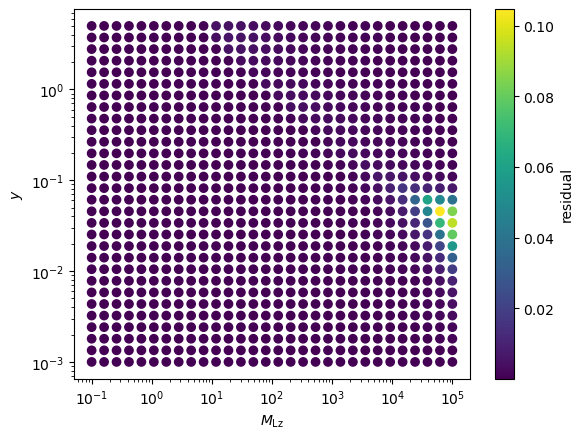

In [10]:
plt.scatter(input_prms[:,0], input_prms[:,1], c=residuals)
plt.colorbar(label='residual')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$M_\mathrm{Lz}$')
plt.ylabel('$y$')
plt.show()

#### max err case

Mlz, y: 62101.694189156166 0.04551546326917438


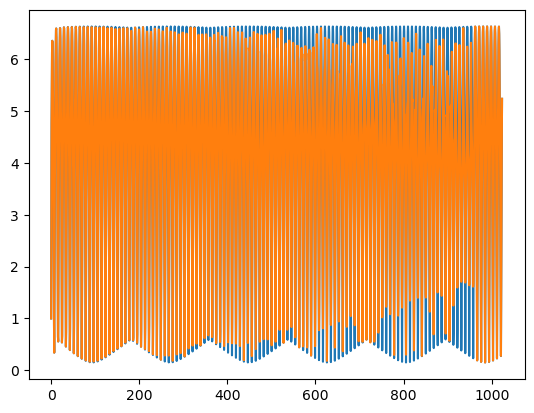

In [11]:
ind = np.argmax(residuals)
Mlz, yl = input_prms[ind]
print('Mlz, y:', Mlz, yl)
Ffs_LT = pnt_Ff_lookup_table(fs, Mlz, yl, ys_grid, ws_grid)
if yl > 1e-2:
    Ffs_A = np.array([pnt_lens_cy.point_Ff_eff(f, Mlz, yl) for f in fs])
else:
    wfs = [pnt_lens_cy.w_of_f(f, Mlz) for f in fs]
    Ffs_A = np.array([pnt_lens_cy.point_Fw(wf, yl) for wf in wfs])

plt.plot(fs, np.abs(Ffs_A))    
plt.plot(fs, np.abs(Ffs_LT))


In [12]:
ind

853

### 2. accuracy for lower values of y < 0.1

100%|██████████| 900/900 [00:38<00:00, 23.60it/s]


0.04522535694970025


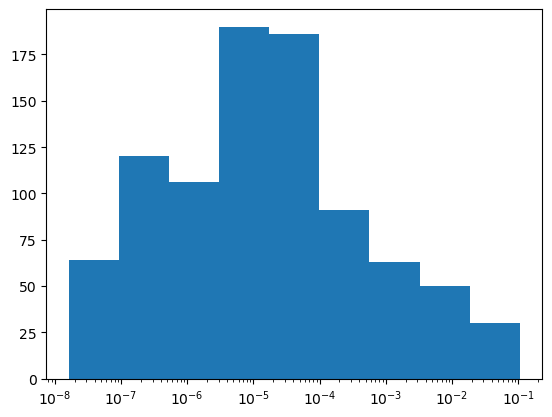

In [13]:
ys_grid, ws_grid = y_w_grid_data(Ff_grid)

t1 = time.time()
Mlzs = np.logspace(-1, 5, 30)
ys = np.logspace(-3, -1, 30)
fs = np.arange(0, 1024, 1/2)
input_prms = np.array(list(product(Mlzs, ys)))

def comp_residual(i):
    Mlz, yl = input_prms[i]
    Ffs_LT = pnt_Ff_lookup_table(fs, Mlz, yl, ys_grid, ws_grid)
    if yl > 1e-2:
        Ffs_A = np.array([pnt_lens_cy.point_Ff_eff(f, Mlz, yl) for f in fs])
    else:
        wfs = [pnt_lens_cy.w_of_f(f, Mlz) for f in fs]
        Ffs_A = np.array([pnt_lens_cy.point_Fw(wf, yl) for wf in wfs])
        
    residual = np.linalg.norm( Ffs_A/np.linalg.norm(Ffs_A) - Ffs_LT/np.linalg.norm(Ffs_LT) )
    return residual

if __name__=='__main__':
    import multiprocessing as mp
    pool = mp.Pool(8)
    residuals = np.array(list(tqdm(pool.imap(comp_residual, np.arange(len(input_prms))), total=len(input_prms))))
    
t2 = time.time()
print((t2-t1)/len(input_prms))

if np.min(residuals) != 0:
    plt.hist(residuals, bins=np.logspace( np.log10(np.min(residuals)), np.log10(np.max(residuals)), 10 ))
else:
    plt.hist(residuals, bins=np.logspace( -10, np.log10(np.max(residuals)), 10 ))
plt.xscale('log')
plt.show()

#### residuals

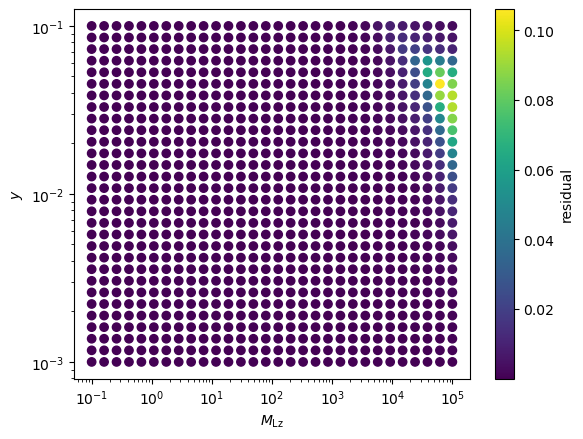

In [14]:
plt.scatter(input_prms[:,0], input_prms[:,1], c=residuals)
plt.colorbar(label='residual')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$M_\mathrm{Lz}$')
plt.ylabel('$y$')
plt.show()

#### max err case

Mlz, y: 62101.694189156166 0.04520353656360243


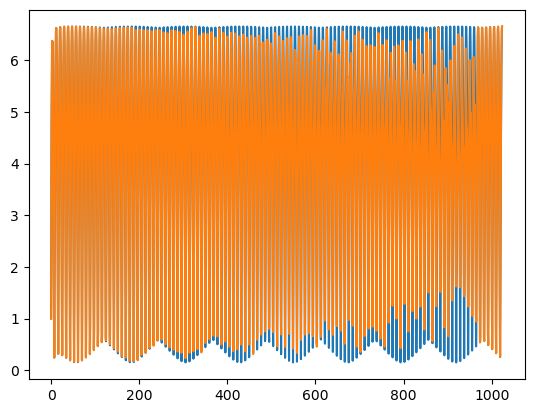

In [15]:
ind = np.argmax(residuals)
Mlz, yl = input_prms[ind]
print('Mlz, y:', Mlz, yl)
Ffs_LT = pnt_Ff_lookup_table(fs, Mlz, yl, ys_grid, ws_grid)
if yl > 1e-2:
    Ffs_A = np.array([pnt_lens_cy.point_Ff_eff(f, Mlz, yl) for f in fs])
else:
    wfs = [pnt_lens_cy.w_of_f(f, Mlz) for f in fs]
    Ffs_A = np.array([pnt_lens_cy.point_Fw(wf, yl) for wf in wfs])

plt.plot(fs, np.abs(Ffs_A))    
plt.plot(fs, np.abs(Ffs_LT))


### 3. accuracy for the higher values of y > 3

100%|██████████| 900/900 [00:21<00:00, 41.08it/s] 


0.027287150224049886


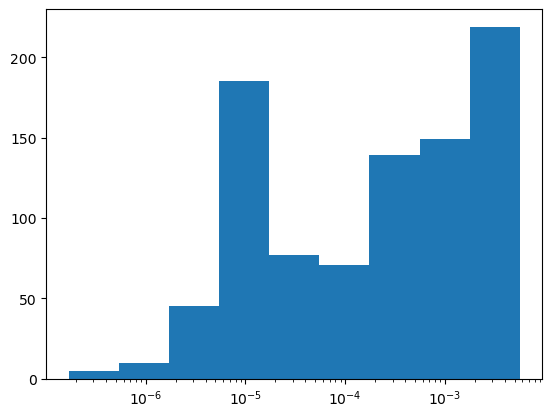

In [19]:
ys_grid, ws_grid = y_w_grid_data(Ff_grid)

t1 = time.time()
Mlzs = np.logspace(-1, 5, 30)
ys = np.logspace(np.log10(3), np.log10(ymax), 30)
fs = np.arange(0, 1024, 1/2)
input_prms = np.array(list(product(Mlzs, ys)))

def comp_residual(i):
    Mlz, yl = input_prms[i]
    Ffs_LT = pnt_Ff_lookup_table(fs, Mlz, yl, ys_grid, ws_grid)
    if yl > 1e-2:
        Ffs_A = np.array([pnt_lens_cy.point_Ff_eff(f, Mlz, yl) for f in fs])
    else:
        wfs = [pnt_lens_cy.w_of_f(f, Mlz) for f in fs]
        Ffs_A = np.array([pnt_lens_cy.point_Fw(wf, yl) for wf in wfs])
        
    residual = np.linalg.norm( Ffs_A/np.linalg.norm(Ffs_A) - Ffs_LT/np.linalg.norm(Ffs_LT) )
    return residual

if __name__=='__main__':
    import multiprocessing as mp
    pool = mp.Pool(8)
    residuals = np.array(list(tqdm(pool.imap(comp_residual, np.arange(len(input_prms))), total=len(input_prms))))
    
t2 = time.time()
print((t2-t1)/len(input_prms))

if np.min(residuals) != 0:
    plt.hist(residuals, bins=np.logspace( np.log10(np.min(residuals)), np.log10(np.max(residuals)), 10 ))
else:
    plt.hist(residuals, bins=np.logspace( -10, np.log10(np.max(residuals)), 10 ))
plt.xscale('log')
plt.show()

#### residuals

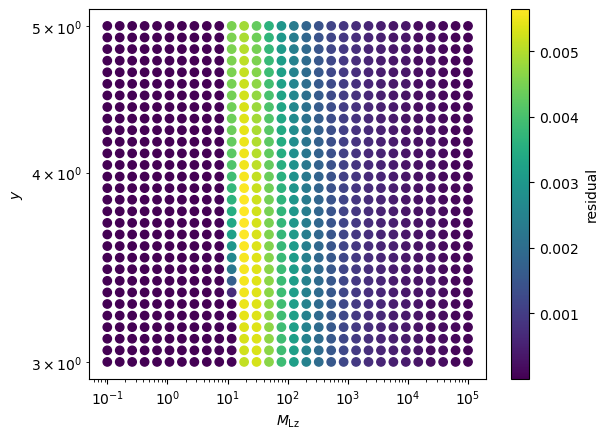

In [20]:
plt.scatter(input_prms[:,0], input_prms[:,1], c=residuals)
plt.colorbar(label='residual')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$M_\mathrm{Lz}$')
plt.ylabel('$y$')
plt.show()

#### max err case

In [21]:
ind = np.argmax(residuals)
Mlz, yl = input_prms[ind]
print('Mlz, y:', Mlz, yl)
Ffs_LT = pnt_Ff_lookup_table(fs, Mlz, yl, ys_grid, ws_grid)
if yl > 1e-2:
    Ffs_A = np.array([pnt_lens_cy.point_Ff_eff(f, Mlz, yl) for f in fs])
else:
    wfs = [pnt_lens_cy.w_of_f(f, Mlz) for f in fs]
    Ffs_A = np.array([pnt_lens_cy.point_Fw(wf, yl) for wf in wfs])

plt.plot(fs, np.abs(Ffs_A))    
plt.plot(fs, np.abs(Ffs_LT))


Mlz, y: 18.873918221350976 3.771991402707145


In [129]:
# Mlz, yl = 200, 4.5
# print('Mlz, y:', Mlz, yl)
# Ffs_LT = pnt_Ff_lookup_table(fs, Mlz, yl, ys_grid, ws_grid)
# if yl > 1e-2:
#     Ffs_A = np.array([pnt_lens_cy.point_Ff_eff(f, Mlz, yl) for f in fs])
# else:
#     wfs = [pnt_lens_cy.w_of_f(f, Mlz) for f in fs]
#     Ffs_A = np.array([pnt_lens_cy.point_Fw(wf, yl) for wf in wfs])

# plt.plot(fs, np.abs(Ffs_A))    
# plt.plot(fs, np.abs(Ffs_LT))
